# Spatial Join
I found a shapes file of the areas in NYC which were flooded by hurricane Sandy.

I joined this with the building permits data to see if the flooding had an affect on the permits being issued.

In [10]:
import pandas as pd
import json
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import pyplot as plt


In [11]:
# Import building permits
read_columns = ['BOROUGH', 'Zip Code', 'Filing Date',
                'LATITUDE', 'LONGITUDE', 'Job Type']
new_or_a1 = ['NB', 'A1']
permits_df = pd.read_csv('DOB_Permit_Issuance.csv', usecols=read_columns)
permits_df = permits_df[permits_df['Job Type'].isin(new_or_a1)]


In [12]:
permits_df['Filing Date'] = pd.to_datetime(permits_df['Filing Date'], errors='coerce')
geometry = [Point(xy) for xy in zip(
    permits_df['LONGITUDE'], permits_df['LATITUDE'])]
permits_gdf = gpd.GeoDataFrame(permits_df, geometry=geometry)
permits_gdf = permits_gdf.set_crs('EPSG:4326')


In [13]:
# Get flood zone shapes and convert to EPSG:4326
sandy_shapes = gpd.read_file('./sandy/sandy.shp')
sandy_shapes_transformed = sandy_shapes.to_crs('EPSG:4326')


In [14]:
# Combine permits data with flood data.
sjoined_df = permits_gdf.sjoin(
    sandy_shapes_transformed, how='left', predicate="within")
sjoined_df['within_flood_zone'] = ~sjoined_df['index_right'].isna()


In [15]:
# Assign boolean for before/after the flooding.
sjoined_df['before_storm'] = sjoined_df['Filing Date'] < '2012-10-31'


In [16]:
# Calculate percentage of permits inside FZ before and after.

before_and_after_flood_df = sjoined_df.groupby(
    ['before_storm', 'within_flood_zone']).size().reset_index(name="count")
pct_in_fz_before_sandy = 100 * before_and_after_flood_df.iloc[3]['count'] / (
    before_and_after_flood_df.iloc[3]['count'] + before_and_after_flood_df.iloc[2]['count'])
pct_in_fz_after_sandy = 100 * before_and_after_flood_df.iloc[1]['count'] / (
    before_and_after_flood_df.iloc[0]['count'] + before_and_after_flood_df.iloc[1]['count'])


Comparison of building permits issued within the flood zone, versus afterwards. The percentage increased by 0.8

In [17]:
results_df = pd.DataFrame({'Permits within flood zone before Sandy': f"{pct_in_fz_before_sandy.round(1)}%",
                          'Permits within flood zone after Sandy': f"{pct_in_fz_after_sandy.round(1)}%"}, index=[0])
results_df.style


,Permits within flood zone before Sandy,Permits within flood zone after Sandy
0,8.9%,9.7%


[Text(0.5, 0, 'Year'), Text(0, 0.5, '% of permits inside FZ')]

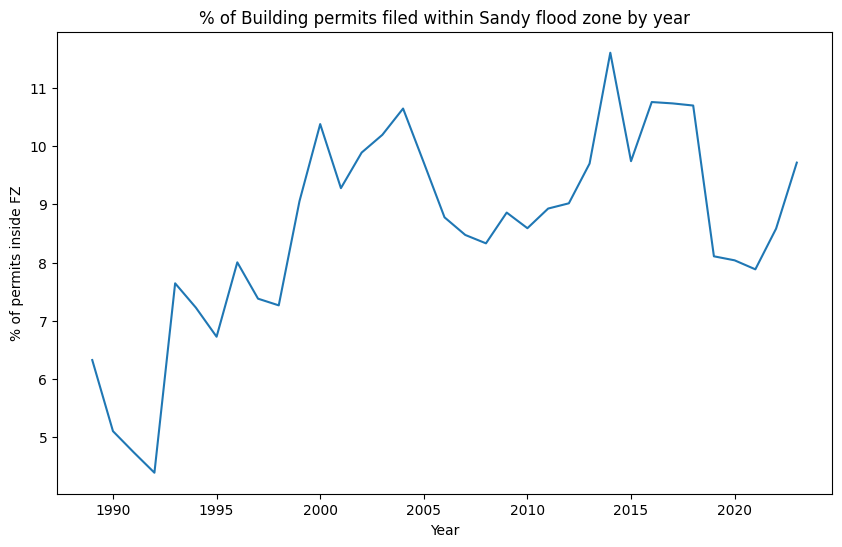

In [18]:
before_and_after_flood_df = sjoined_df.groupby(
    [sjoined_df['Filing Date'].dt.year, 'within_flood_zone']).size().reset_index(name="count")
pivoted_df = before_and_after_flood_df.pivot(
    index='Filing Date', columns='within_flood_zone', values='count')
pivoted_df['pct_within_fz'] = (
    pivoted_df[True] / (pivoted_df[True] + pivoted_df[False])) * 100

chart = pivoted_df['pct_within_fz'].plot(
    title="% of Building permits filed within Sandy flood zone by year", figsize=(10, 6))
chart.set(xlabel="Year", ylabel="% of permits inside FZ")


# Analysis

There is no clear trend. It seems to be a slight increase, but this could be impacted by any number of factors.